# SimFin Tutorial 09 - Machine Learning

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"I hate these bloody automated machines. I'm not a machine, I'm a human being! It's remarkable the technology these days, it says it's not a machine, it says it's a human being!"
&ndash; [Fonejacker](https://www.youtube.com/watch?v=MFqxdvggAxM)

## Introduction

In the previous tutorial on Statistical Analysis, we tried to find a linear relation between signals and future stock-returns for all 1-3 year investment periods. But it was clear from the scatter-plots in that tutorial, that the relations were not linear as assumed by the statistical model. Although it is possible to use non-linear statistical models, we would need to provide the exact mathematical formula, which we often do not know.

In this tutorial we will try and use so-called Machine Learning (ML) to automatically try and discover the non-linear relations between signals and stock-returns. Machine Learning has become a fashionable buzz-word, that people sometimes think is a super-intelligent robot that can solve any problem. In reality, ML models are more or less flexible algorithms that can map from some input x (e.g. signals) to some output y (e.g. stock-returns). The ML model may change parts of its algorithm and/or tune its parameters to the dataset, to achieve a good mapping between input x and output y. There are pro's and con's to different ML models, and each ML model may work on some problems but not on others.

This tutorial shows how to use financial data from SimFin with the scikit-learn library for doing the Machine Learning. It is assumed you are already familiar with both.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# Scikit-learn imports.
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.3.0'

## SimFin Config

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

We use a `StockHub` object to easily load and process financial data with these settings:

In [6]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [7]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 17.2 µs


## Signals

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [8]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (1 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 14.3 s, sys: 1 s, total: 15.3 s
Wall time: 15.3 s


Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [9]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 830 ms, sys: 292 ms, total: 1.12 s
Wall time: 1.12 s


Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [10]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 110 ms, sys: 309 ms, total: 419 ms
Wall time: 416 ms


We now combine all the signals into a single DataFrame:

In [11]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 1.61 s, sys: 216 ms, total: 1.83 s
Wall time: 1.82 s


We can then show the results:

In [12]:
df_signals.dropna(how='all').head()

Asset Turnover  Current Ratio  Debt Ratio  \
Ticker Date                                                    
A      2011-06-29             NaN       3.201005     0.24789   
       2011-06-30             NaN       3.201005     0.24789   
       2011-07-01             NaN       3.201005     0.24789   
       2011-07-05             NaN       3.201005     0.24789   
       2011-07-06             NaN       3.201005     0.24789   

                   Gross Profit Margin  Net Profit Margin  Return on Assets  \
Ticker Date                                                                   
A      2011-06-29             0.532001           0.144574               NaN   
       2011-06-30             0.532001           0.144574               NaN   
       2011-07-01             0.532001           0.144574               NaN   
       2011-07-05             0.532001           0.144574               NaN   
       2011-07-06             0.532001           0.144574               NaN   

                   Return on Equity  Earnings Growth  Earnings Growth QOQ  \
Ticker Date                                                                 
A      2011-06-29               NaN              NaN                  NaN   
       2011-06-30               NaN              NaN                  NaN   
       2011-07-01               NaN              NaN                  NaN   
       2011-07-05               NaN              NaN                  NaN   
       2011-07-06               NaN              NaN                  NaN   

                   Earnings Growth YOY  ...  Dividend Yield  Earnings Yield  \
Ticker Date                             ...                                   
A      2011-06-29                  NaN  ...             NaN        0.049626   
       2011-06-30                  NaN  ...             NaN        0.049121   
       2011-07-01                  NaN  ...             NaN        0.048280   
       2011-07-05                  NaN  ...             NaN        0.048598   
       2011-07-06                  NaN  ...             NaN        0.048448   

                   FCF Yield    Market-Cap    P/Book        P/E      P/FCF  \
Ticker Date                                                                  
A      2011-06-29   0.045221  1.793416e+10  4.527684  20.150736  22.113631   
       2011-06-30   0.044761  1.811850e+10  4.574222  20.357860  22.340931   
       2011-07-01   0.043995  1.843400e+10  4.653875  20.712360  22.729963   
       2011-07-05   0.044284  1.831347e+10  4.623446  20.576933  22.581344   
       2011-07-06   0.044148  1.837019e+10  4.637766  20.640663  22.651282   

                      P/NCAV   P/NetNet   P/Sales  
Ticker Date                                        
A      2011-06-29  43.956262 -29.990226  2.913281  
       2011-06-30  44.408076 -30.298487  2.943225  
       2011-07-01  45.181373 -30.826087  2.994477  
       2011-07-05  44.885956 -30.624532  2.974898  
       2011-07-06  45.024975 -30.719381  2.984111  

[5 rows x 26 columns]

## Missing Data

Some of the signals have a lot of missing data which cannot be handled by scikit-learn. Let us first see the fraction of each signal-column that is missing:

In [13]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

Dividend Yield         0.533772
Debt Ratio             0.324557
Sales Growth           0.227931
Asset Turnover         0.224232
Earnings Growth        0.212780
Return on Assets       0.212388
Return on Equity       0.212388
FCF Growth             0.212388
Sales Growth YOY       0.198149
Earnings Growth YOY    0.184320
FCF Growth YOY         0.183868
P/Sales                0.105850
Sales Growth QOQ       0.095425
Earnings Yield         0.091799
P/NetNet               0.091799
FCF Yield              0.091799
Market-Cap             0.091799
P/Book                 0.091799
P/E                    0.091799
P/FCF                  0.091799
P/NCAV                 0.091799
Gross Profit Margin    0.083246
Net Profit Margin      0.080159
Earnings Growth QOQ    0.077892
FCF Growth QOQ         0.077380
Current Ratio          0.065622
dtype: float64

Let us remove all signals that have more than 25% missing data:

In [14]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Debt Ratio', 'Dividend Yield'], dtype='object')

## 1-3 Year Returns

We want to try and predict the average 1-3 year returns. We will actually consider the mean log-returns, because that is easier to calculate, but the result is nearly the same as the non-log mean returns.

In [15]:
# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [16]:
%%time
# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

Cache-file 'mean_log_change-5cec82bd.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 61.5 ms, sys: 40.2 ms, total: 102 ms
Wall time: 102 ms


## Combine Signals & Returns

We then combine the signals and returns into a single DataFrame to align the data.

In [17]:
%%time
dfs = [df_signals, df_returns_1_3y]
df_sig_rets = pd.concat(dfs, axis=1)

CPU times: user 840 ms, sys: 103 ms, total: 944 ms
Wall time: 945 ms


## Data Cleaning

The data also contains outliers and still has missing values, so let us fix that now. A common method for removing outliers is so-called *Winsorization* of the data. It basically just limits or clips the data between e.g. the 5% and 95% quantiles of the data. We will Winsorize both the stock-returns and all the signals. After that, we will remove all rows with missing values, because scikit-learn cannot handle that. Finally we will remove tickers that have less than 200 rows of data.

There are more than 5 million data-rows before this cleaning:

In [18]:
df_sig_rets.shape

(5450093, 25)

In [19]:
%%time

# Clip the signals and returns at their 5% and 95% quantiles.
# We do not set them to NaN because it would remove too much data.
df_sig_rets = sf.winsorize(df_sig_rets)

# Remove all rows with missing values (NaN)
# because scikit-learn cannot handle that.
df_sig_rets = df_sig_rets.dropna(how='any')

# Remove all tickers which have less than 200 data-rows.
df_sig_rets = df_sig_rets.groupby(TICKER) \
                .filter(lambda df: len(df)>200)

CPU times: user 4.4 s, sys: 973 ms, total: 5.37 s
Wall time: 5.37 s


This data-cleaning has removed about 80% of the rows, which is a lot:

In [20]:
df_sig_rets.shape

(1109909, 25)

The reason that so many rows have been removed, is that scikit-learn cannot handle rows with missing values (NaN). Some missing values could be set to a default value, e.g. the Dividend Yield could be set to 0. Other columns could be omitted because they don't have any predictive power anyway. Or you could try another Machine Learning library that can handle missing values, such as [XGBoost](https://xgboost.readthedocs.io/en/latest/).

## Correlation: Signals vs. Return

Linear correlation (aka. Pearson correlation) is a simple statistical measure of how two variables change together. The linear correlation between the signals and stock-returns can be used to assess which signals might be the best predictors for stock-returns.

A correlation value of +1 means the two variables are perfectly correlated, so they always increase and decrease together in a linear way. Conversely, a correlation value of -1 means the two variables are perfectly inversely correlated, so they always increase and decrease in the opposite direction of each other. A correlation value of zero means that there is no linear relation between the signal and stock-returns, but there may still be a strong non-linear relation (see examples [here](https://en.wikipedia.org/wiki/Correlation_and_dependence)).

We use the Winsorized data when studying the correlation, because data-outliers may falsely indicate a strong overall correlation, when in fact there is no correlation for the majority of the data.

The following calculates the correlation between all the signals and the 1-3 year average stock-returns, sorted according to the absolute correlation strength:

In [21]:
# New column-name for correlation between signals and returns.
RETURN_CORR = 'Return Correlation'

# Calculate the correlation between all data-columns.
df_corr = df_sig_rets.corr()

# Correlation between signals and returns.
# Sorted to show the strongest absolute correlations first.
df_corr_returns = df_corr[TOTAL_RETURN_1_3Y] \
                    .abs() \
                    .drop(TOTAL_RETURN_1_3Y) \
                    .sort_values(ascending=False) \
                    .rename(RETURN_CORR)

# Show the correlations between signals and returns.
df_corr_returns

Net Profit Margin      0.148644
Return on Assets       0.127358
Earnings Yield         0.121156
FCF Yield              0.108249
Return on Equity       0.088707
P/E                    0.079911
Market-Cap             0.077844
P/FCF                  0.058703
Asset Turnover         0.042455
FCF Growth             0.038051
P/Book                 0.037959
Earnings Growth        0.034542
P/NetNet               0.027178
Current Ratio          0.027121
Earnings Growth QOQ    0.022299
P/NCAV                 0.022142
FCF Growth QOQ         0.021533
FCF Growth YOY         0.019968
Earnings Growth YOY    0.019081
Sales Growth YOY       0.017120
Sales Growth           0.012584
Gross Profit Margin    0.010173
Sales Growth QOQ       0.003194
P/Sales                0.000482
Name: Return Correlation, dtype: float64

## Split Training / Test-Sets

When training a Machine Learning model, we typically split the dataset into training- and test-sets. Only the training-set is used to train the model, after which the model is used on the test-set, to assess how the model performs on data it has not seen during training.

If we randomly divide all the data-rows into training- and test-sets, we would most likely get data for every stock-ticker in both the training- and test-sets, which would probably make them highly correlated. To avoid this, we split the dataset according to stock-tickers, so a ticker belongs to either the training- or test-set, but not both. We use 80% of all the tickers in the training-set, and 20% in the test-set.

In [22]:
# List of all unique stock-tickers in the dataset.
tickers = df_sig_rets.reset_index()[TICKER].unique()

# Split the tickers into training- and test-sets.
tickers_train, tickers_test = \
    train_test_split(tickers, train_size=0.8, random_state=1234)

Now that we have lists of tickers for the training- and test-sets, we can select those rows from the DataFrame with signals and stock-returns:

In [23]:
%%time
df_train = df_sig_rets.loc[tickers_train]
df_test = df_sig_rets.loc[tickers_test]

CPU times: user 3.05 s, sys: 15.8 ms, total: 3.07 s
Wall time: 3.06 s


We can then split these DataFrames into signals and stock-returns; that is, X and y-values that the Machine Learning model must try and find a mapping between. In scikit-learn's notation, the capital X indicates a 2-dimensional array or matrix, and the lower-case y indicates a 1-dimensional array.

In [24]:
# DataFrames with signals for training- and test-sets.
X_train = df_train.drop(columns=[TOTAL_RETURN_1_3Y])
X_test = df_test.drop(columns=[TOTAL_RETURN_1_3Y])

# DataFrames with stock-returns for training- and test-sets.
y_train = df_train[TOTAL_RETURN_1_3Y]
y_test = df_test[TOTAL_RETURN_1_3Y]

Let us check that the shapes of these arrays look reasonable:

In [25]:
X_train.shape, y_train.shape

((890400, 24), (890400,))

In [26]:
X_test.shape, y_test.shape

((219509, 24), (219509,))

## Helper Functions

These are some helper-functions for printing and plotting the results.

In [27]:
# List of signal names.
signal_names = X_train.columns.values

# List of signal names where spaces are replaced with _
signal_names_ = [s.replace(' ', '_') for s in signal_names]

In [28]:
# Column-name.
FEATURE_IMPORTANCE = 'Feature Importance'

In [29]:
def compare_feature_imp_corr(estimator):
    """
    Return a DataFrame which compares the signals' Feature
    Importance in the Machine Learning model, to the absolute
    correlation of the signals and stock-returns.
    
    :param estimator: Sklearn ensemble estimator.
    :return: Pandas DataFrame.
    """
    
    # Wrap the list of Feature Importance in a Pandas Series.
    df_feat_imp = pd.Series(estimator.feature_importances_,
                            index=signal_names,
                            name=FEATURE_IMPORTANCE)

    # Concatenate the DataFrames with Feature Importance
    # and Return Correlation.
    dfs = [df_feat_imp, df_corr_returns]
    df_compare = pd.concat(dfs, axis=1, sort=True)
    
    # Sort by Feature Importance.
    df_compare.sort_values(by=FEATURE_IMPORTANCE,
                           ascending=False, inplace=True)
    
    return df_compare

In [30]:
def print_tree(estimator, max_depth=6, **kwargs):
    """
    Print the first Decision Tree from a Random Forest.
    :param estimator: Sklearn ensemble estimator.
    """
    s = export_text(estimator.estimators_[0],
                    max_depth=max_depth,
                    feature_names=signal_names_,
                    **kwargs)
    print(s)

In [31]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a classification confusion matrix.
    
    :param y_true: Array of true classes.
    :param y_pred: Array of predicted classes.
    """
    
    # Class labels.
    labels = [1.0, -1.0]
    labels_text = ['Gain', 'Loss']

    # Create confusion matrix.
    mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
                           labels=labels)
    
    # Normalize so all matrix entries sum to 1.0
    mat = mat / len(y_true)
    
    # Plot the matrix as a heatmap.
    sns.heatmap(mat, robust=True,
                xticklabels=labels_text,
                yticklabels=labels_text)

## Machine Learning: Regression

Now that the data has been prepared, we can create a Machine Learning model using scikit-learn. Because we want to map financial signals x to stock-returns y that are continuous values, we need to use a so-called Regression model. In this example, we will use a Random Forest which is an ensemble of many Decision Trees, because it computes fairly quickly. An example of a Decision Tree will be shown further below, once the model has been fitted to the training-data.

The model has many parameters that adjust its ability to fit the training-data, possibly at the cost of having a worse fit on the test-data. This is the usual dilemma between over- and under-fitting the model to the training-data. If we overfit the model, it means that it has learned to recognize noise in the training-data which does not generalize to the test-set. Conversely, if we underfit the model, it means that it has not learned some essential features in the training-data that also generalize to the test-data.

You can tweak these parameters to try and improve the model's performance on the training- and test-sets.

In [32]:
# Parameters for scikit-learn's Random Forest models.
model_args = \
{
    # Random Forest parameters to adjust between
    # over- and under-fitting.
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 100,
    'min_samples_leaf': 10,

    # Use all available CPU cores.
    'n_jobs': -1,

    # Set random seed to make the experiments repeatable.
    'random_state': 1234,
}

In [33]:
# Create the estimator, but don't do any computations yet.
regr = RandomForestRegressor(**model_args)

In [34]:
%%time
# Fit the estimator to the training-data.
# This may take several minutes on a 4-core CPU.
_ = regr.fit(X=X_train, y=y_train)

CPU times: user 31min 58s, sys: 3.1 s, total: 32min 1s
Wall time: 4min 21s


Now that the Random Forest model has been fitted to the training-data, we can show one of the 100 Decision Trees that it found. These are deeply nested if-then-else statements on the signals, which result in some output value. The output of 100 such Decision Trees are averaged to create the output of the entire ensemble known as a Random Forest.

Clearly, the model does not contain any profound insight. It does not understand anything about finance. The model has just found that it could estimate the mapping between signals x and stock-returns y in the training-data, using many of these finely tuned if-then-else statements.

In [35]:
print_tree(regr)

|--- P/FCF <= 5.57
|   |--- Net_Profit_Margin <= 0.01
|   |   |--- Asset_Turnover <= 0.43
|   |   |   |--- Return_on_Equity <= 0.00
|   |   |   |   |--- Sales_Growth_YOY <= -0.24
|   |   |   |   |   |--- Current_Ratio <= 7.63
|   |   |   |   |   |   |--- P/Sales <= 0.68
|   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |--- P/Sales >  0.68
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |--- Current_Ratio >  7.63
|   |   |   |   |   |   |--- FCF_Yield <= -0.17
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |--- FCF_Yield >  -0.17
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |--- Sales_Growth_YOY >  -0.24
|   |   |   |   |   |--- Return_on_Assets <= -0.07
|   |   |   |   |   |   |--- P/NCAV <= 1.44
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |--- P/NCAV >  1.44
|   |   |   |   |   |   |   |--- truncated branch 

We can also show the mutual importance of the signals (aka. features) in the model, and compare it to their correlation with the stock-returns. These are often quite different. The signals with highest correlations to the future stock-returns, are not necessarily the ones that were most important to the model. But remember that correlation only measures the linear relation between signals and stock-returns, while the Random Forest can find complicated non-linear relations.

In [36]:
compare_feature_imp_corr(regr)

,Feature Importance,Return Correlation
Gross Profit Margin,0.093591,0.010173
Market-Cap,0.078742,0.077844
Asset Turnover,0.073532,0.042455
Current Ratio,0.066175,0.027121
Sales Growth,0.056123,0.012584
Return on Equity,0.053956,0.088707
P/FCF,0.052208,0.058703
Earnings Growth,0.046735,0.034542
Net Profit Margin,0.045677,0.148644
P/NetNet,0.045224,0.027178


### Regression Results

Let us now see how well the Machine Learning model performs. First we use the fitted model to predict the stock-returns for the training- and test-sets:

In [37]:
%%time
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

CPU times: user 7.61 s, sys: 67.7 ms, total: 7.68 s
Wall time: 1.19 s


We can then calculate the $R^2$ value (aka. the coefficient of determination) between the actual stock-returns and those predicted by the model. A value of 1 means a perfect prediction, while a value of 0 means the model basically predicted the average stock-return, and a negative value means the model's prediction was worse than just using the average stock-return.

As we can see, the $R^2$ value is quite high for the training-set, so the model has learned to map the signals X to stock-returns y quite well for the training-set:

In [38]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.8439779739975598

But the $R^2$ value is very bad for the test-set, so the model has not really learned the underlying relation between the signals X and stock-returns y. The model has merely learned noise or peculiarities in the training-data, which do not generalize to the unseen data in the test-set:

In [39]:
r2_score(y_true=y_test, y_pred=y_test_pred)

-0.09531061662990048

### Regression Examples

We can also try and plot the model's predicted versus actual stock-returns for a stock in the training-set. As we can see, the model has learned this mapping quite well:

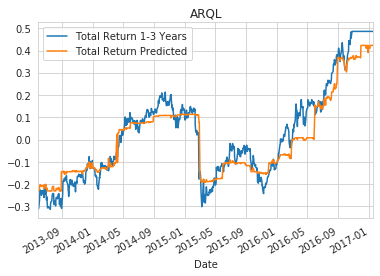

In [40]:
# Column-name for the models' predicted stock-returns.
TOTAL_RETURN_PRED = 'Total Return Predicted'

# Create a DataFrame with actual and predicted stock-returns.
# This is for the training-set.
df_y_train = pd.DataFrame(y_train)
df_y_train[TOTAL_RETURN_PRED] = y_train_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[0]
_ = df_y_train.loc[ticker].plot(title=ticker)

Now let us try and plot the model's predicted versus actual stock-returns for the first stock in the test-set. As we can see, the model is completely unable to predict the stock-returns, for this data that it has not seen during its training:

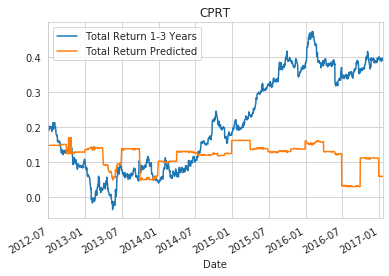

In [41]:
# Create a DataFrame with actual and predicted stock-returns.
# This is for the test-set.
df_y_test = pd.DataFrame(y_test)
df_y_test[TOTAL_RETURN_PRED] = y_test_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[0]
_ = df_y_test.loc[ticker].plot(title=ticker)

## Machine Learning: Classification

Instead of mapping from signals x to a continuous variable y for the stock-return, we can try and map to discrete output-classes that indicate if the stock-return was a gain or loss. This is a so-called binary classification problem, and perhaps that is easier for the Machine Learning model.

First we need to convert the stock-returns into values of either 1.0 for gains or -1.0 for losses, and then split into training- and test-sets:

In [42]:
%%time
# Convert stock-returns to binary classes by taking the sign.
df_cls = np.sign(df_sig_rets[TOTAL_RETURN_1_3Y])

# Split the classes into training- and test-sets.
y_train_cls = df_cls.loc[tickers_train]
y_test_cls = df_cls.loc[tickers_test]

CPU times: user 3.01 s, sys: 12 ms, total: 3.02 s
Wall time: 3.02 s


The training-set is biased because it contains many more stocks with gains than losses:

In [43]:
# Fraction of the training-set that is classified as gains.
(y_train_cls == 1.0).sum() / len(y_train_cls)

0.7068901617250674

We instruct the Machine Learning model to take this bias into account, by setting `class_weight='balanced'`, and otherwise use the same arguments as above:

In [44]:
clf = RandomForestClassifier(class_weight='balanced', **model_args)

We can then fit the model to the training-data. This is much faster then for the regression model above, because we only have a binary class as output:

In [45]:
%%time
_ = clf.fit(X=X_train, y=y_train_cls)

CPU times: user 5min 40s, sys: 777 ms, total: 5min 41s
Wall time: 46.1 s


As for the regression model above, the Random Forest consists of 100 Decision Trees, which are basically just nested if-then-else statements that split the input signals, to try and find a mapping that fits the input and output of the training-data.

In [46]:
print_tree(clf)

|--- Net_Profit_Margin <= 0.01
|   |--- FCF_Yield <= 0.00
|   |   |--- Sales_Growth <= -0.01
|   |   |   |--- Return_on_Equity <= -0.21
|   |   |   |   |--- P/E <= -37.03
|   |   |   |   |   |--- Earnings_Growth <= 1.23
|   |   |   |   |   |   |--- FCF_Growth_YOY <= 1.04
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- FCF_Growth_YOY >  1.04
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Earnings_Growth >  1.23
|   |   |   |   |   |   |--- P/NCAV <= 8.30
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- P/NCAV >  8.30
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- P/E >  -37.03
|   |   |   |   |   |--- FCF_Growth_QOQ <= -0.38
|   |   |   |   |   |   |--- Gross_Profit_Margin <= 0.25
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |--- Gross_Profit_Margin >  0.25
|   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |--- FCF_Growth_QOQ >  

We can also show the signals (or features) that the model found were most important. These are not necessarily the signals that are best correlated with stock-returns, because the Random Forest is a non-linear mapping from signals to the gain/loss classification.

In [47]:
compare_feature_imp_corr(clf)

,Feature Importance,Return Correlation
Market-Cap,0.080069,0.077844
Gross Profit Margin,0.060903,0.010173
Net Profit Margin,0.058858,0.148644
Asset Turnover,0.057307,0.042455
Return on Equity,0.050487,0.088707
Current Ratio,0.049986,0.027121
Sales Growth,0.048909,0.012584
Return on Assets,0.047656,0.127358
P/NCAV,0.044325,0.022142
P/Sales,0.041323,0.000482


### Classification Results

We can then use the fitted model to predict the classes for the training- and test-sets:

In [48]:
%%time
y_train_pred_cls = clf.predict(X_train)
y_test_pred_cls = clf.predict(X_test)

CPU times: user 11.7 s, sys: 35.9 ms, total: 11.8 s
Wall time: 1.78 s


The model has a very high classification accuracy on the training-set, so the model has learned to map financial signals to gain/loss classifications for 1-3 year investment periods:

In [49]:
accuracy_score(y_true=y_train_cls, y_pred=y_train_pred_cls)

0.9711758760107817

Unfortunately this performance does not generalize to the test-set, which the model has not seen during training. Here the classification accuracy is much lower:

In [50]:
accuracy_score(y_true=y_test_cls, y_pred=y_test_pred_cls)

0.6710749900915225

This is about the same score as simply guessing that the stock-returns are always gains:

In [51]:
# Fraction of the test-set that is classified as gains.
(y_test_cls == 1.0).sum() / len(y_test_cls)

0.7024723359862238

### Confusion Matrix

We can also plot a so-called Confusion Matrix, which shows how the classes were predicted. For the training-set, we again see that the model has learned to accurately classify gains and losses. Note how the colours are different, because the training-set contains many more gains than losses.

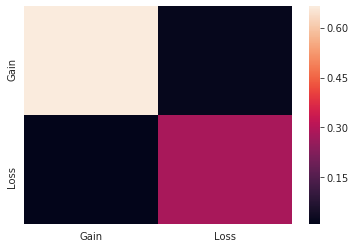

In [52]:
plot_confusion_matrix(y_true=y_train_cls, y_pred=y_train_pred_cls)

The confusion matrix for the test-set, shows that most classes were predicted as gains:

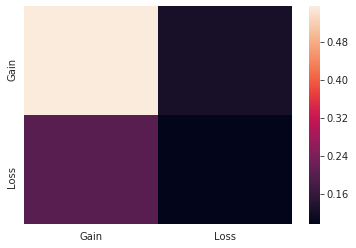

In [53]:
plot_confusion_matrix(y_true=y_test_cls, y_pred=y_test_pred_cls)

### Classification Examples

We can also try and plot the model's predicted versus actual gain/loss classification for a stock in the training-set. As we can see, the model has learned this mapping reasonably well:

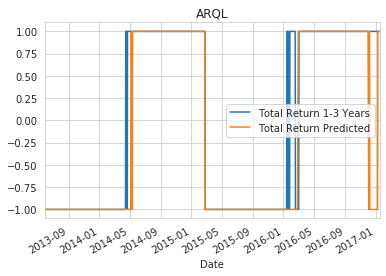

In [54]:
# Create a DataFrame with actual and predicted classifications.
# This is for the training-set.
df_y_train_cls = pd.DataFrame(y_train_cls)
df_y_train_cls[TOTAL_RETURN_PRED] = y_train_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[0]
_ = df_y_train_cls.loc[ticker].plot(title=ticker)

Now let us try and plot the model's predicted versus actual gain/loss classifications for the first stock in the test-set. As we can see, the model is quite bad at predicting this for data that it has not seen during its training:

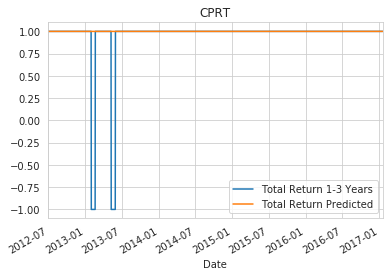

In [55]:
# Create a DataFrame with actual and predicted classifications.
# This is for the test-set.
df_y_test_cls = pd.DataFrame(y_test_cls)
df_y_test_cls[TOTAL_RETURN_PRED] = y_test_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[0]
_ = df_y_test_cls.loc[ticker].plot(title=ticker)

## Discussion

We used a Machine Learning model called a Random Forest to learn the relation between signals and future stock-returns. This worked well on the training-data, but did not generalize to the test-data, where the model performed about the same as guessing.

The reason must be that either these signals could not be used to predict future stock-returns, or this particular Machine Learning model could not find the true relation between the signals and stock-returns, or we need to experiment with different settings and parameters when training the model.

You could spend a very long time experimenting with different ML models and settings, to try and improve the performance. There is a much easier way, by using a "meta" Machine Learning system such as [TPOT](https://github.com/EpistasisLab/tpot), which automatically tries to find a combination of Machine Learning models that gives optimal performance. It is easy to use because it has the same API as scikit-learn, but it may take several days to run.


### Machine Learning vs. Good Science

In general, these experiments show that Machine Learning cannot replace good science. Even if the ML model had performed well on the test-data, it would not have provided an explanation for the underlying relation between signals and stock-returns, so we would not know whether it was truly something that would work in the future. To explain this we need proper scientific reasoning.

A good example of scientific reasoning is the discovery and formulation of the Law of Gravity. A simple experiment would be to drop various items from different heights and take lots of measurements of how fast the items fall to the ground.

You can then make a noisy scatter-plot that shows the relation between item-size, item-weight, drop-height, and drop-speed. Statistical analysis would be able to give you a rough idea whether there is some relation in the data and if it is statistically significant, so the observed data is probably not just due to random chance. 

Machine Learning takes this one step further, in that it might be able to create a mathematical or computational model for the non-linear relation in the data, so you could use the ML model to predict the drop-speed if you input the other data. But the ML model would not be able to explain *why* this relation exists in the data. For this we need a proper theoretical framework such as Classical Mechanics in the case of the Law of Gravity.


### Predicting Long-Term Stock Returns

When it comes to predicting long-term stock-returns, there are actually only 3 factors that matter: The future dividends, sales-growth, and change in the P/Sales valuation ratio. (You could instead use earnings-growth or book-value growth, and the P/E or P/Book valuation ratios.) If we can predict the future dividend, sales-growth and P/Sales ratio, then we can predict the future stock-return.

When making scatter-plots of historical P/Sales ratios versus long-term stock-returns, we often see a particular downwards-sloping curve, and it turns out there is a certain formula for this curve, which is derived from the mathematical definition of Annualized Return, see [here](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb). The formula takes as input the average dividend yield, sales-growth and P/Sales ratios that you predict for the future, and produces a curve that can be used to predict future stock-returns from these 3 factors and the P/Sales ratio today. The accuracy of the prediction depends on how well you have predicted these 3 factors.

Machine Learning cannot uncover and explain such relations, whether it is the Law of Gravity, or the formula for long-term stock-returns. Human reasoning is still needed for this.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
